# Polish bankrupt companies analysis
## Dataset link - http://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data

## Goals of the analysis:
- Find  indicators, that have the most valuable impact of companies bankruptcy
- Find some insights and hidden patterns in data
- Build a model, that can as accurate as possible predict the company's bankruptcy
- - Especially, maximize recall - minimize false negatives

## Key takeaways from the analysis:
- profit on operating activities / financial expenses is the key metric in context of bankruptcy risk
- Missingness of values in metrics are related to each other in most cases
- Relation between bankrupt and non-bankrupt companies is similar for 5 years


## Libraries importing

In [75]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import warnings
warnings.filterwarnings("ignore")
from colorama import Fore, Back, Style
import seaborn as sns
import missingno as msno
from fancyimpute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

## Data importing and basic descriptitve statistics of variables

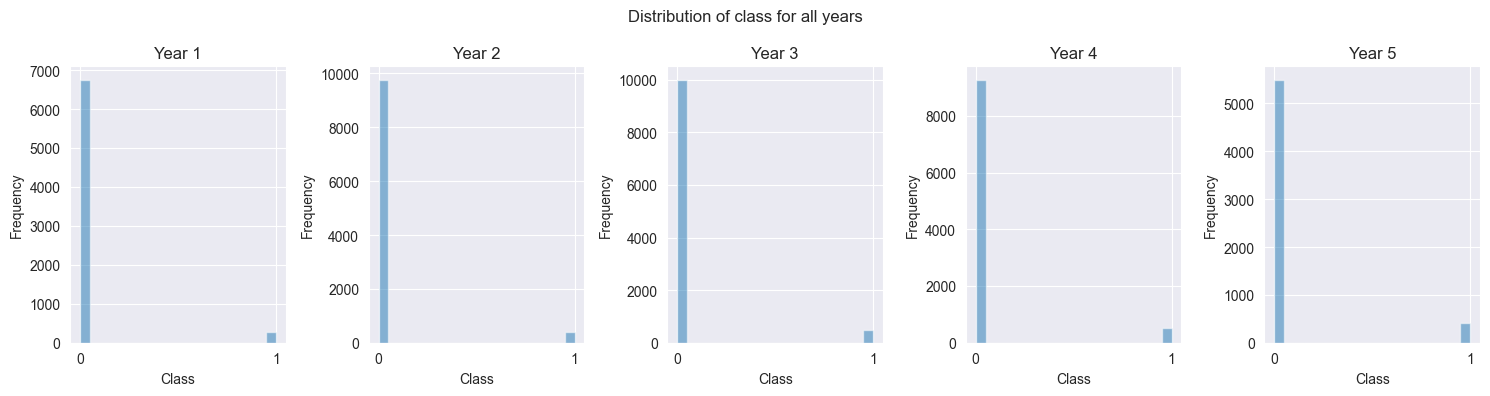

In [53]:
arff_files = ['data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff']
data_frames = []

#merging data
for arff_file in arff_files:
    data, meta = arff.loadarff(arff_file)
    df = pd.DataFrame(data)
    data_frames.append(df)

#making data for visualization

fig, axs = plt.subplots(1, 5, figsize=(15, 4))
# Changing the target variable to acceptable format + visuallizing differences between years
for i, df in enumerate(data_frames):
    df['class'] = df['class'].astype(str).str.replace("b'", "").str.replace("'", "").astype('category')

    # Plotting the distribution
    axs[i].hist(df['class'], bins=20, alpha=0.5)
    axs[i].set_title('Year ' + str(i+1))
    axs[i].set_xlabel('Class')
    axs[i].set_ylabel('Frequency')

plt.suptitle('Distribution of class for all years')
plt.tight_layout()
plt.show()

merged_data = pd.concat(data_frames, ignore_index=True)




In [54]:
merged_data.head(10)
merged_data.info()
merged_data.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Attr1   43397 non-null  float64 
 1   Attr2   43397 non-null  float64 
 2   Attr3   43397 non-null  float64 
 3   Attr4   43271 non-null  float64 
 4   Attr5   43316 non-null  float64 
 5   Attr6   43397 non-null  float64 
 6   Attr7   43397 non-null  float64 
 7   Attr8   43311 non-null  float64 
 8   Attr9   43396 non-null  float64 
 9   Attr10  43397 non-null  float64 
 10  Attr11  43361 non-null  float64 
 11  Attr12  43271 non-null  float64 
 12  Attr13  43278 non-null  float64 
 13  Attr14  43397 non-null  float64 
 14  Attr15  43369 non-null  float64 
 15  Attr16  43310 non-null  float64 
 16  Attr17  43311 non-null  float64 
 17  Attr18  43397 non-null  float64 
 18  Attr19  43277 non-null  float64 
 19  Attr20  43278 non-null  float64 
 20  Attr21  37551 non-null  float64 
 21  Attr22  4339

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,...,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000,43405
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41314
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,...,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592,NaN
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,...,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482,NaN
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000,NaN
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,...,9.348500e-03,0.014649,8.753200e-01,0.000000,5.545500e+00,4.510150,4.214400e+01,3.097650,2.176800,NaN
50%,0.049660,0.471900,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,0.505970,...,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500,NaN
75%,0.129580,0.688320,0.403390,2.787450,5.063425e+01,0.089446,0.150880,2.615700,2.062500,0.709100,...,1.290975e-01,0.284605,9.926400e-01,0.236052,2.018100e+01,10.394500,1.172200e+02,8.598850,9.776200,NaN


## Basic understanding of target variable

In [55]:
print(merged_data['class'].dtype)
merged_data.head(10)

category


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.379510,0.396410,2.0472,32.3510,0.38825,0.249760,1.33050,1.13890,0.50494,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.6580,4.4158,7.4277,0
1,0.209120,0.499880,0.472250,1.9447,14.7860,0.00000,0.258340,0.99601,1.69960,0.49788,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.3500,3.4000,60.9870,0
2,0.248660,0.695920,0.267130,1.5548,-1.1523,0.00000,0.309060,0.43695,1.30900,0.30408,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.2700,2.7185,5.2078,0
3,0.081483,0.307340,0.458790,2.4928,51.9520,0.14988,0.092704,1.86610,1.05710,0.57353,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.4350,4.2228,5.5497,0
4,0.187320,0.613230,0.229600,1.4063,-7.3128,0.18732,0.187320,0.63070,1.15590,0.38677,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.2100,2.8692,7.8980,0
5,0.228220,0.497940,0.359690,1.7502,-47.7170,0.00000,0.281390,1.00830,1.97860,0.50206,...,0.139320,0.454570,0.85891,0.023002,3.4028,8.9949,88.4440,4.1269,12.2990,0
6,0.111090,0.647440,0.289710,1.4705,2.5349,0.00000,0.111090,0.54454,1.73480,0.35256,...,0.605900,0.315100,0.40871,0.000000,6.3222,2.9098,129.5500,2.8173,18.3520,0
7,0.532320,0.027059,0.705540,53.9540,299.5800,0.00000,0.652400,35.95700,0.65273,0.97294,...,0.086730,0.547130,0.49521,0.013194,9.1300,82.0500,7.4503,48.9910,2.3217,0
8,0.009020,0.632020,0.053735,1.1263,-37.8420,0.00000,0.014434,0.58223,1.33320,0.36798,...,0.180110,0.024512,0.84165,0.340940,9.9665,4.2382,116.5000,3.1330,2.5603,0
9,0.124080,0.838370,0.142040,1.1694,-91.8830,0.00000,0.153280,0.19279,2.11560,0.16163,...,0.079665,0.767680,0.92847,0.000000,3.3192,6.4994,144.6300,2.5236,107.6700,0


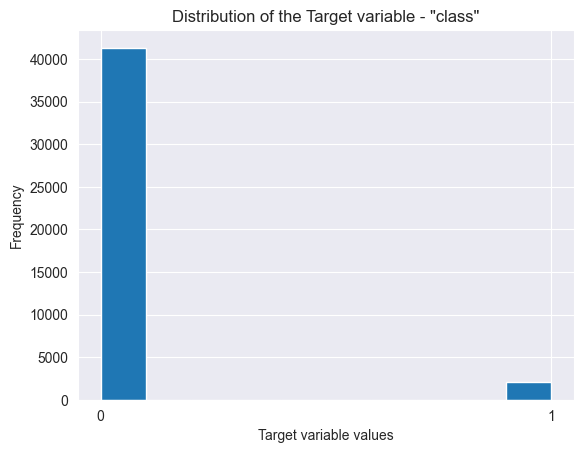

In [56]:
plt.hist(merged_data['class'])
plt.xlabel('Target variable values')
plt.ylabel('Frequency')
plt.title('Distribution of the Target variable - "class"')
plt.show()

## Intermediate conclusion about data:
- Target variable is imbalance: amount of non-bankrupt companies out weigh companies, that were labeled as bankrupts.
- From this statement additional resampling will be needed, that should help us to make more precise models.
- Last, we can suppose, that data treat with overabundance of variables. To check this, we should to make the Infromation Value evaluation for each feature to conclude, which of all predictors are the most useful to predict the Target variable.

## NA values handling:

In [57]:
all_values = len(merged_data)
string_NA = f"{(merged_data.isna().any(axis=1).sum() / all_values) * 100:.2f} % of observations contain NA values"
color = Back.LIGHTBLUE_EX
text_color = Fore.BLACK
print(f"{color}{text_color}{string_NA}{Style.RESET_ALL}")

54.00 % of observations contain NA values


### Let's see NA values distribution:

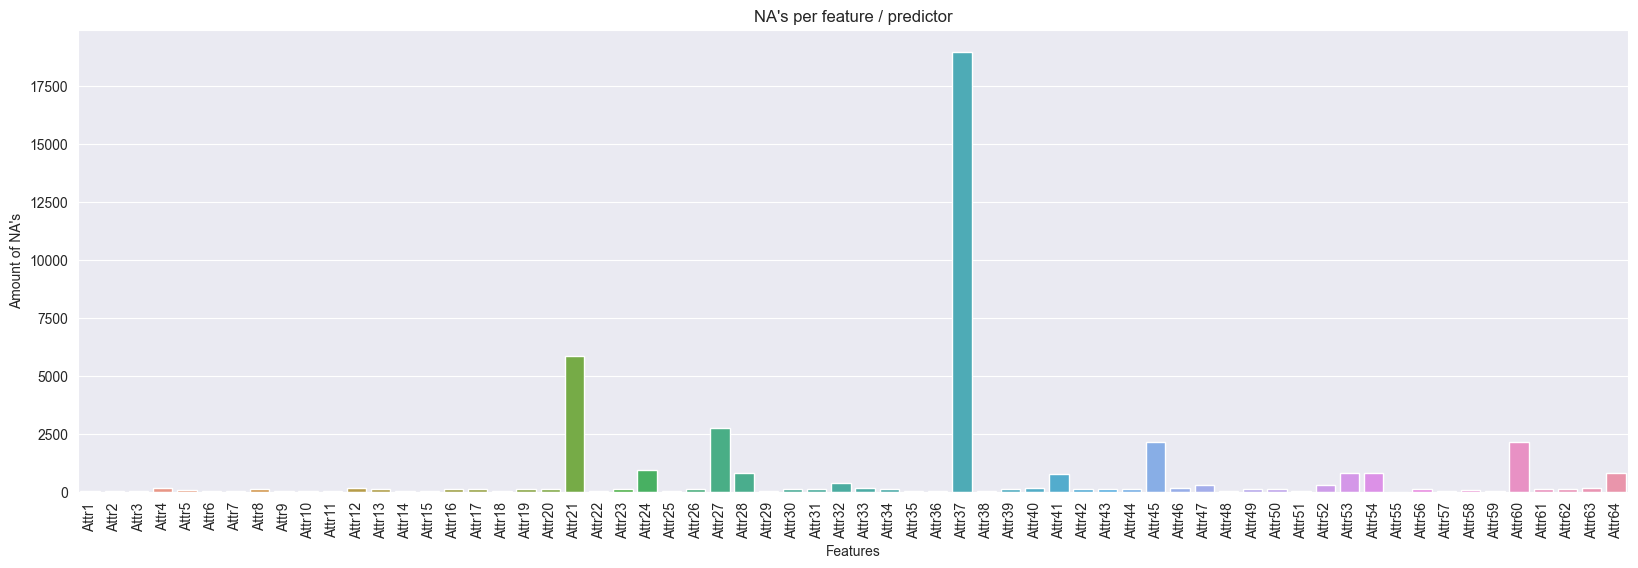

In [58]:
predictors = merged_data.columns[merged_data.columns != 'class']
na_counts = merged_data[predictors].isna().sum()
plt.figure(figsize=(20, 6))
sns.barplot(x=na_counts.index, y=na_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel("Amount of NA's")
plt.title("NA's per feature / predictor")
plt.show()

### Missingness patterns:

<Figure size 1900x1500 with 0 Axes>

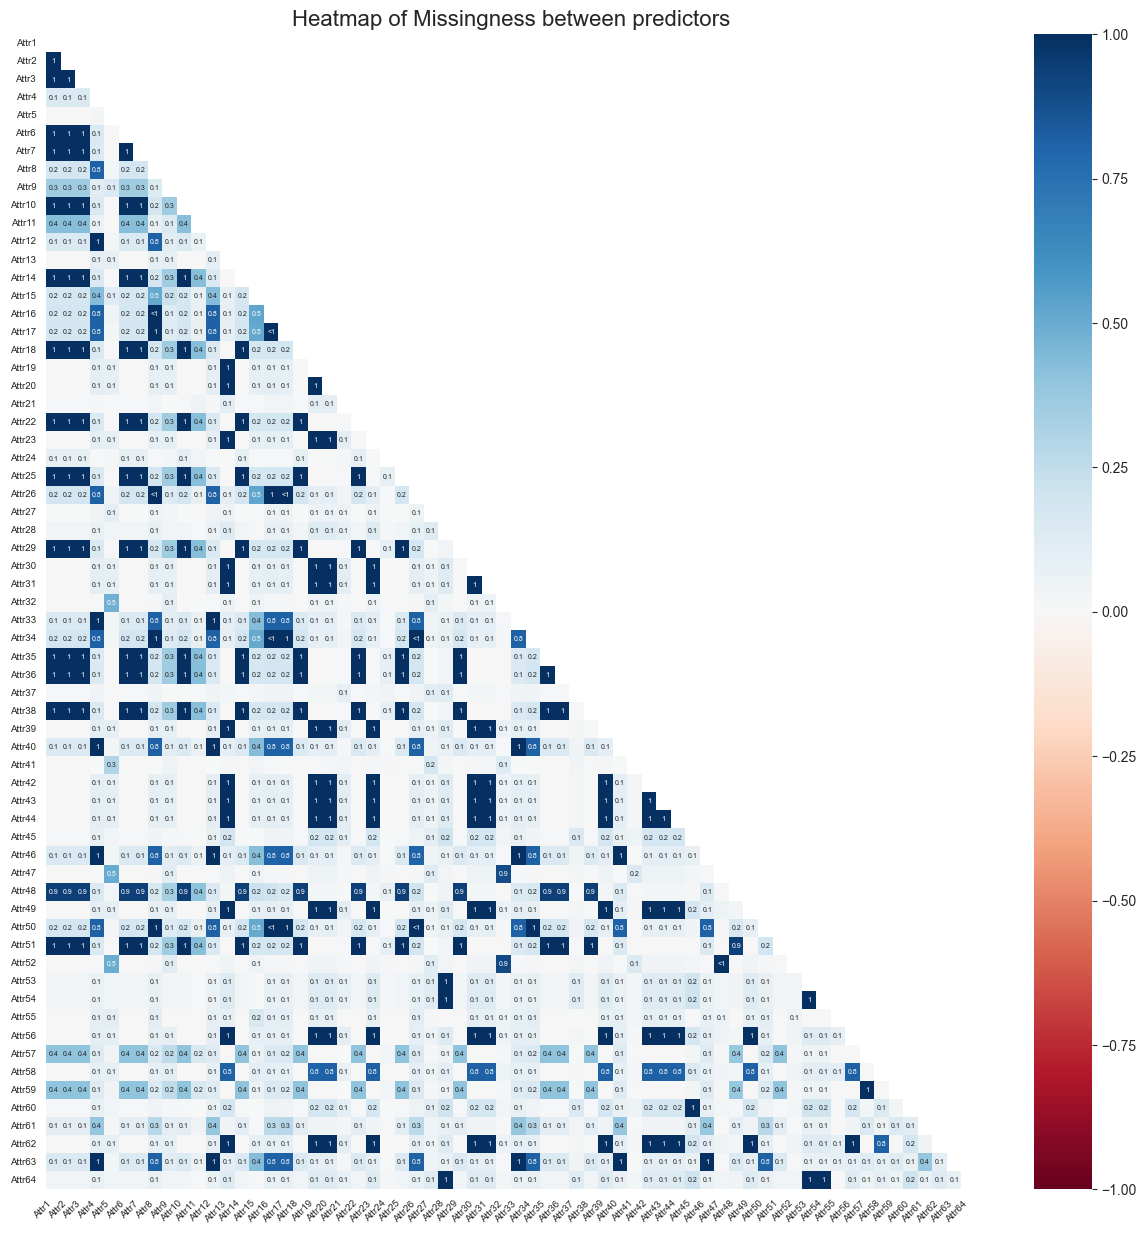

In [59]:
plt.figure(figsize=(19, 15))
msno.heatmap(merged_data[predictors], figsize=(15, 15), fontsize=7, labels=True)
plt.title('Heatmap of Missingness between predictors', fontsize=16)
plt.show()

## As we can see, plenty of variables are related between each other in terms of missingness and we can conclude, that our data falls to MAR (missing at random) category. Now, we can predict our NA values based on other variables / values.

## Information value evaluation:

In [60]:

def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [61]:
merged_data['class'] = merged_data['class'].astype(int)
iv, woe = iv_woe(data=merged_data, target='class', bins=10, show_woe=False)
print(iv)


Information value of Attr1 is 0.457773
Information value of Attr2 is 0.385983
Information value of Attr3 is 0.31379
Information value of Attr4 is 0.353869
Information value of Attr5 is 0.281964
Information value of Attr6 is 0.476344
Information value of Attr7 is 0.459015
Information value of Attr8 is 0.389911
Information value of Attr9 is 0.12102
Information value of Attr10 is 0.385917
Information value of Attr11 is 0.485939
Information value of Attr12 is 0.522662
Information value of Attr13 is 0.590514
Information value of Attr14 is 0.459015
Information value of Attr15 is 0.516467
Information value of Attr16 is 0.644957
Information value of Attr17 is 0.387658
Information value of Attr18 is 0.459361
Information value of Attr19 is 0.486253
Information value of Attr20 is 0.053708
Information value of Attr21 is 0.288002
Information value of Attr22 is 0.405024
Information value of Attr23 is 0.488203
Information value of Attr24 is 0.672818
Information value of Attr25 is 0.453663
Information

In [62]:
strong_predictors = iv[iv['IV'] >= 0.5]['Variable']
custom_predictors = iv[iv['IV'] >= 0.5]
custom_predictors


,Variable,IV
0,Attr12,0.522662
0,Attr13,0.590514
0,Attr15,0.516467
0,Attr16,0.644957
0,Attr24,0.672818
0,Attr26,0.655671
0,Attr27,1.120499
0,Attr35,0.501282
0,Attr39,0.509361
0,Attr41,0.605801


## After our feature selection procedure, using IV, I decided to set threshold to >= 0.5, which can contradict with initial IV values classification, but it's helping us to extract the most valuable variables and avoid overfitting at the same time.

In [63]:
filltered_data = merged_data[strong_predictors]
filltered_data['bankruptcy'] = merged_data['class']
filltered_data.head(10)

,Attr12,Attr13,Attr15,Attr16,Attr24,Attr26,Attr27,Attr35,Attr39,Attr41,Attr46,bankruptcy
0,0.659800,0.166600,497.420,0.733780,0.477060,0.604110,1.45820,0.214020,0.128040,0.051402,1.52250,0
1,0.516800,0.158350,677.960,0.538380,NaN,0.439920,88.44400,0.206160,0.121300,0.064371,1.12520,0
2,0.641840,0.244350,794.160,0.459610,NaN,0.372820,86.01100,0.315650,0.241140,0.074020,1.01010,0
3,0.301630,0.094257,917.010,0.398030,0.171930,0.361520,0.94076,0.115500,0.088995,0.069622,1.56960,0
4,0.331470,0.121820,1133.200,0.322110,0.187320,0.322110,1.41380,0.198320,0.122310,0.096680,0.95787,0
5,0.586910,0.148120,620.140,0.588580,NaN,0.481810,55.51100,0.275660,0.139320,0.056701,0.53744,0
6,0.180410,0.309630,439.940,0.829650,NaN,0.829650,0.00000,0.024982,0.014400,0.050653,1.02490,0
7,48.966000,1.060200,14.272,25.575000,NaN,21.137000,16.15800,0.056612,0.086730,0.001269,48.58800,0
8,0.033921,0.038938,4443.700,0.082138,0.000222,0.073572,1.07140,0.240130,0.180110,0.308650,0.81192,0
9,0.182840,0.075411,1918.100,0.190300,NaN,0.155470,5.05920,0.168540,0.079665,0.169940,0.40912,0


## 5 most valuable predictors of bankruptcy are: (according to data description.txt)
- profit on operating activities / financial expenses
- gross profit (in 3 years) / total assets
- (net profit + depreciation) / total liabilities
- (gross profit + depreciation) / total liabilities
- total liabilities / ((profit on operating activities + depreciation) * (12/365))


## Working with edited dataset:
### Checking for NA distribution

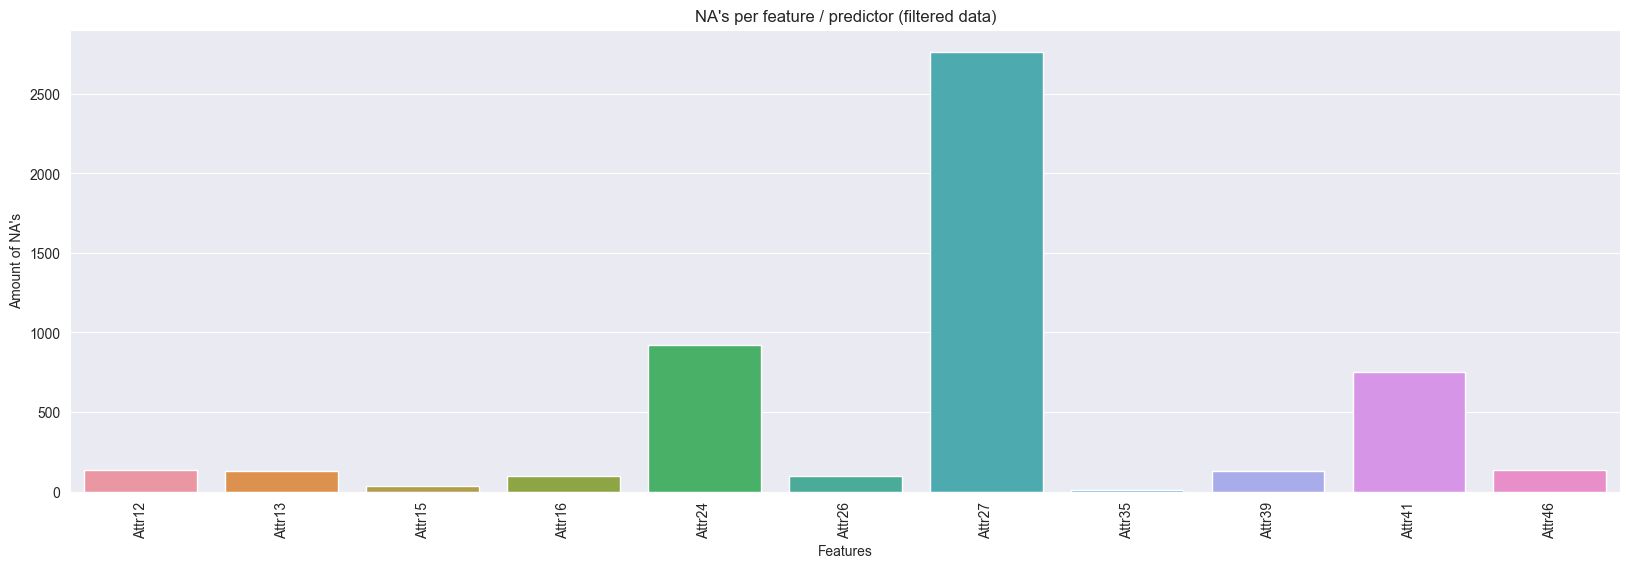

In [64]:
na_counts_filtered = filltered_data[strong_predictors].isna().sum()
plt.figure(figsize=(20, 6))
sns.barplot(x=na_counts_filtered.index, y=na_counts_filtered.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel("Amount of NA's")
plt.title("NA's per feature / predictor (filtered data)")
plt.show()

<Figure size 1000x1000 with 0 Axes>

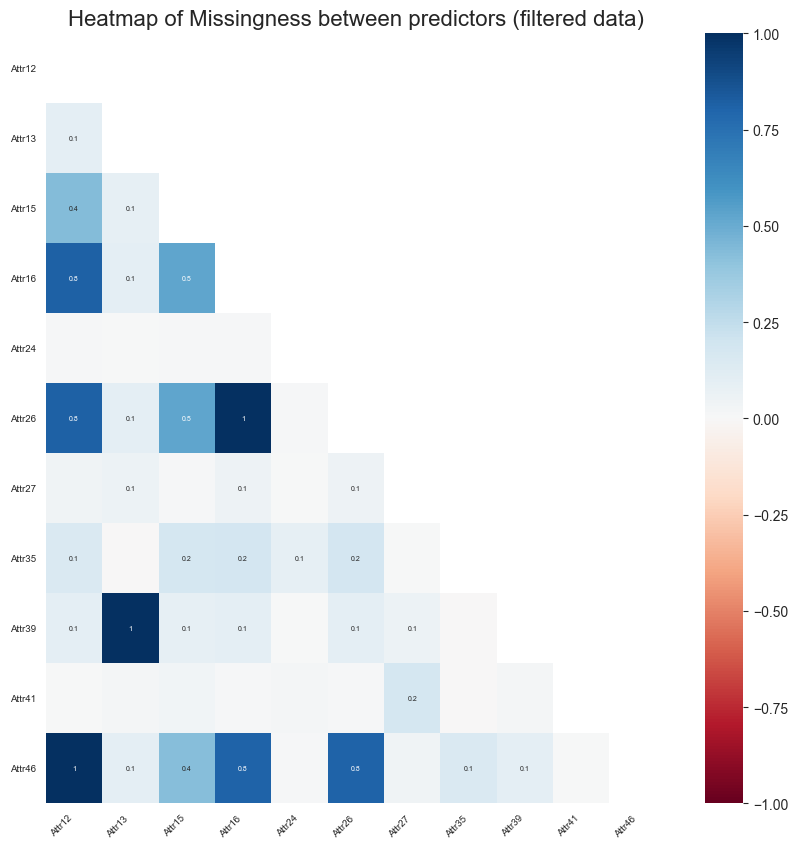

In [65]:
plt.figure(figsize=(10, 10))
msno.heatmap(filltered_data[strong_predictors], figsize=(10, 10), fontsize=7, labels=True)
plt.title('Heatmap of Missingness between predictors (filtered data)', fontsize=16)
plt.show()

In [66]:
strong_pred_edited = filltered_data.drop(columns=['bankruptcy'])
target_strong = filltered_data['bankruptcy']

mult_imputer = IterativeImputer()
imputed_predictors = mult_imputer.fit_transform(strong_pred_edited)

clean_data = pd.DataFrame(imputed_predictors, columns=strong_pred_edited.columns)
clean_data['bankruptcy'] = target_strong

print(clean_data.head(10))
print(clean_data.isna().sum())

      Attr12    Attr13    Attr15     Attr16    Attr24     Attr26    Attr27  \
0   0.659800  0.166600   497.420   0.733780  0.477060   0.604110   1.45820   
1   0.516800  0.158350   677.960   0.538380  0.420251   0.439920  88.44400   
2   0.641840  0.244350   794.160   0.459610  0.588168   0.372820  86.01100   
3   0.301630  0.094257   917.010   0.398030  0.171930   0.361520   0.94076   
4   0.331470  0.121820  1133.200   0.322110  0.187320   0.322110   1.41380   
5   0.586910  0.148120   620.140   0.588580  0.524070   0.481810  55.51100   
6   0.180410  0.309630   439.940   0.829650  0.163177   0.829650   0.00000   
7  48.966000  1.060200    14.272  25.575000 -0.423598  21.137000  16.15800   
8   0.033921  0.038938  4443.700   0.082138  0.000222   0.073572   1.07140   
9   0.182840  0.075411  1918.100   0.190300  0.373504   0.155470   5.05920   

     Attr35    Attr39    Attr41    Attr46  bankruptcy  
0  0.214020  0.128040  0.051402   1.52250           0  
1  0.206160  0.121300  0.0643

## Linear relationship between predictors and target variable
### It may be considered to have multicollinearity, but some of those metrics are directly correlated between each other

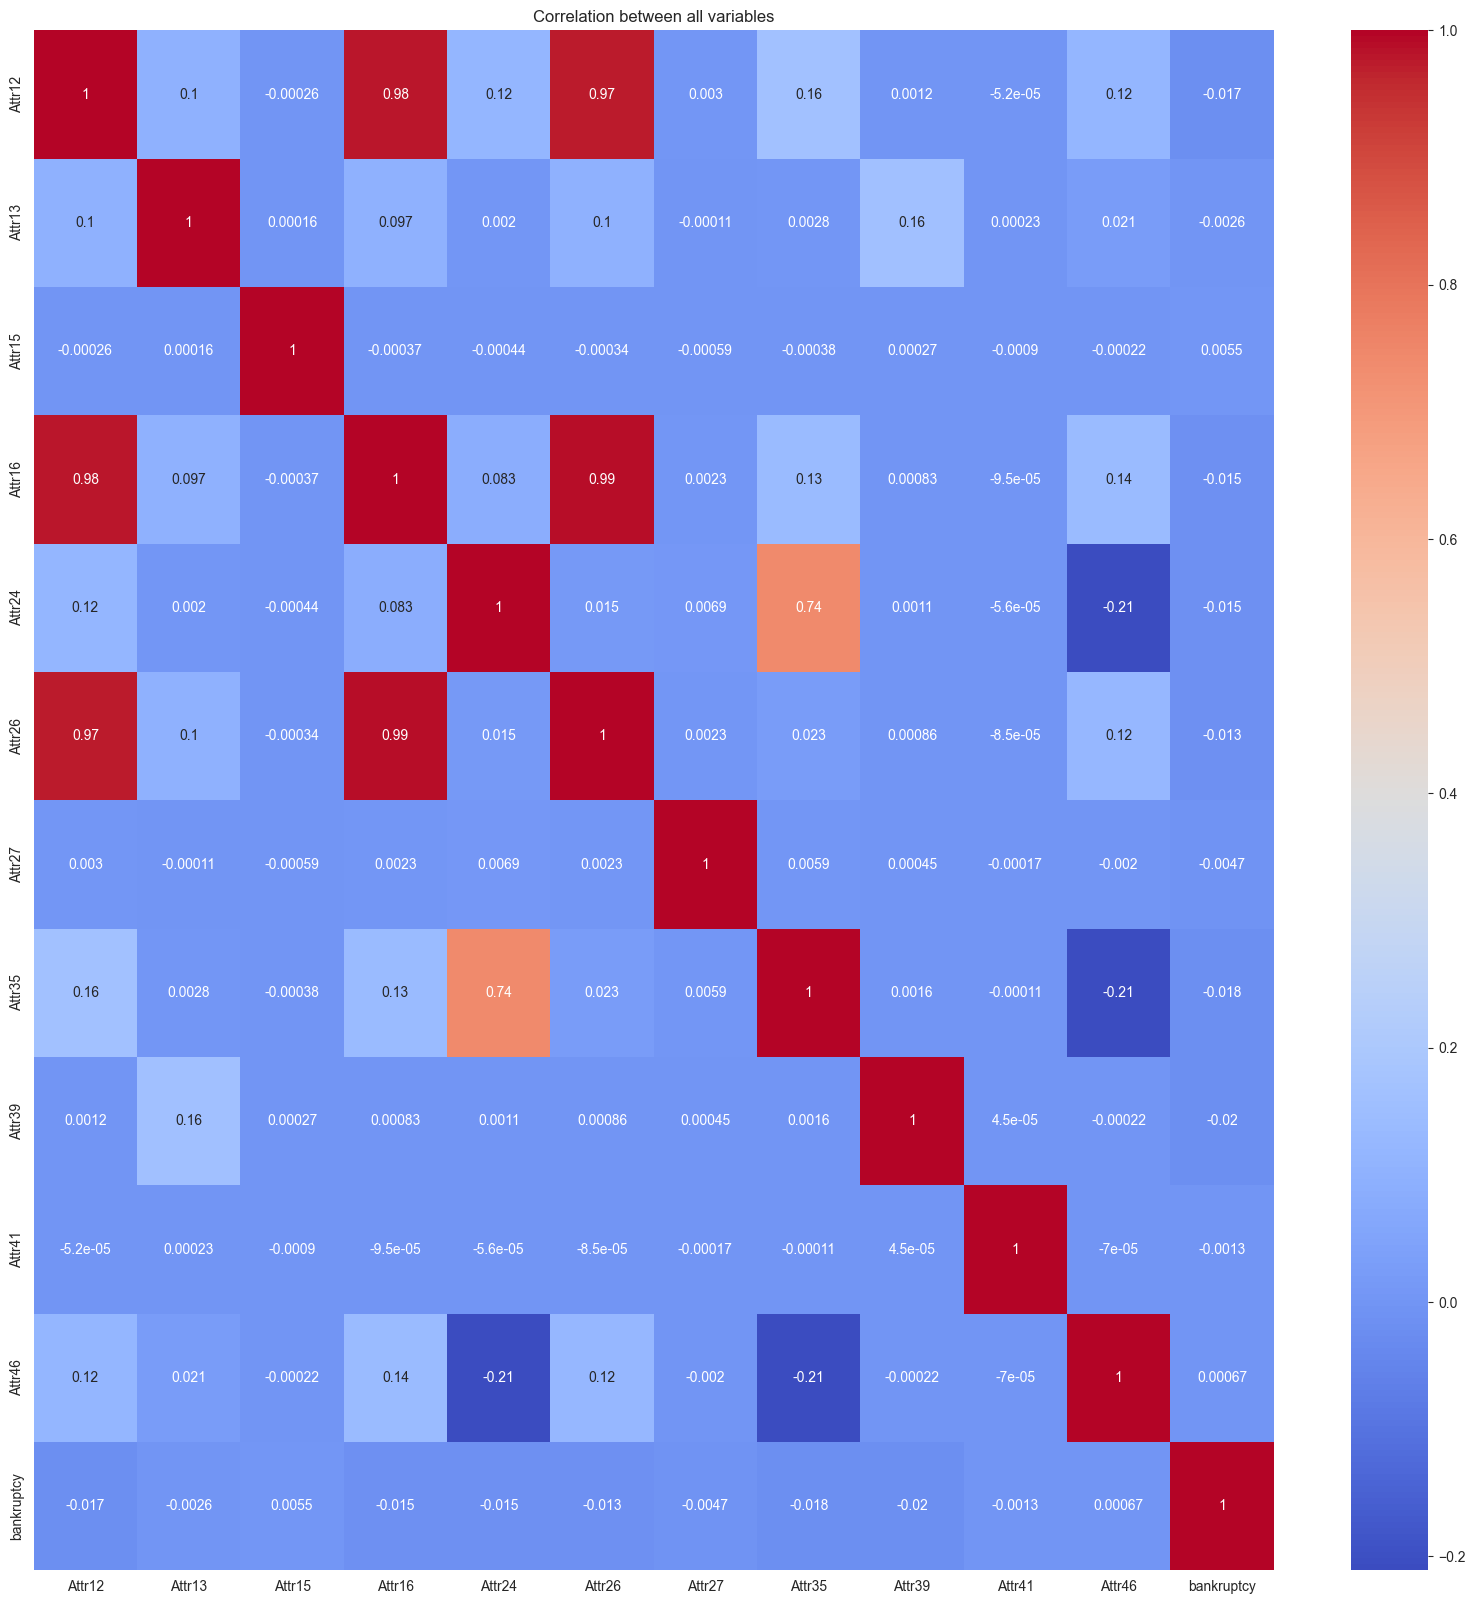

In [67]:
plt.figure(figsize=(20, 20))
sns.heatmap(clean_data.corr(), annot=True, cmap="coolwarm")
plt.title('Correlation between all variables')
plt.show()

## Resampling
### As I noticed above, this step helps us to solve target variable imbalancing problem to make more realistic predictions

In [68]:
X = clean_data.drop('bankruptcy', axis=1)
y = clean_data['bankruptcy']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=35)

smote = SMOTE(random_state=20)
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

# Results of resampling, now our dataset is balanced.
print(Counter(y_train))
print(Counter(smote_y_train))


Counter({0: 33068, 1: 1656})
Counter({0: 33068, 1: 33068})


## Modelling
### Decision Tree

In [69]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(smote_X_train, smote_y_train)
dec_tree_predict = dec_tree.predict(X_test)
print("Accuracy with resampling: ",accuracy_score(y_test, dec_tree_predict))
print("Precision  with resampling: ", precision_score(y_test, dec_tree_predict))
print("Recall with resampling: ", recall_score(y_test, dec_tree_predict))
print("F1 score with resampling: ", f1_score(y_test, dec_tree_predict))


Accuracy with resampling:  0.8729409054256422
Precision  with resampling:  0.2007168458781362
Recall with resampling:  0.5149425287356322
F1 score with resampling:  0.28884590586718245


### ROC curve - Decision Tree

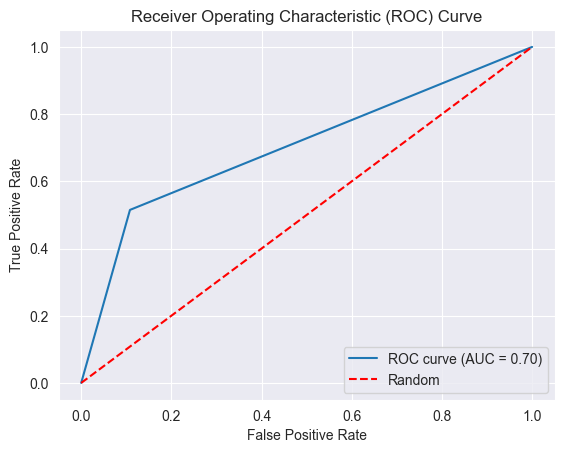

In [70]:
predicted_probs_dec_tree = dec_tree.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, predicted_probs_dec_tree)
auc = roc_auc_score(y_test, predicted_probs_dec_tree)
plt.plot(fpr_dt, tpr_dt, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random', color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Decision Tree: performance without resampling 

In [71]:
dec_tree.fit(X_train, y_train)
dec_tree_predict_default = dec_tree.predict(X_test)
print("Accuracy without resampling: ",accuracy_score(y_test, dec_tree_predict_default))
print("Precision  without resampling: ", precision_score(y_test, dec_tree_predict_default))
print("Recall without resampling: ", recall_score(y_test, dec_tree_predict_default))
print("F1 score without resampling: ", f1_score(y_test, dec_tree_predict_default))

Accuracy without resampling:  0.9314595092731253
Precision  without resampling:  0.3190045248868778
Recall without resampling:  0.32413793103448274
F1 score without resampling:  0.3215507411630559


### Logistic Regression

In [72]:
log_reg = LogisticRegression()
log_reg.fit(smote_X_train, smote_y_train)
log_reg_predict = log_reg.predict(X_test)
print("Accuracy with resampling: ",accuracy_score(y_test, log_reg_predict))
print("Precision  with resampling: ", precision_score(y_test, log_reg_predict))
print("Recall with resampling: ", recall_score(y_test, log_reg_predict))
print("F1 score with resampling: ", f1_score(y_test, log_reg_predict))

Accuracy with resampling:  0.8096993433936183
Precision  with resampling:  0.11657214870825457
Recall with resampling:  0.42528735632183906
F1 score with resampling:  0.18298714144411474


### ROC Curve - Logistic Regression

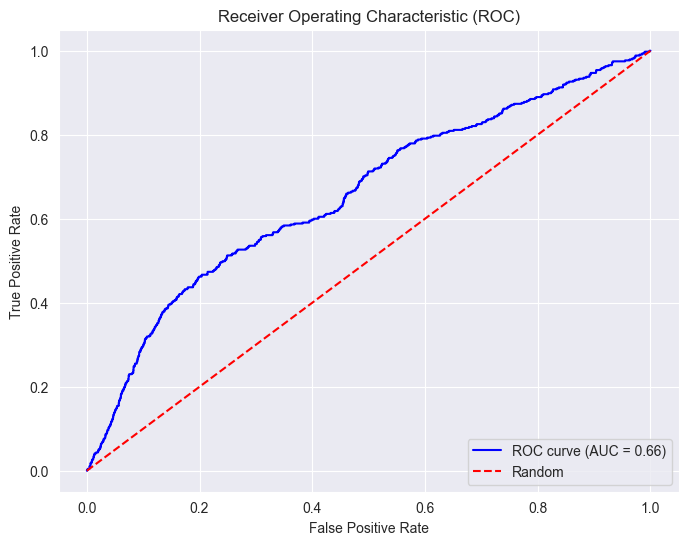

In [76]:
predicted_probs = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [77]:
distances = 1 - fpr + tpr
optimal_threshold_index = np.argmax(distances)
optimal_threshold = thresholds[optimal_threshold_index]
print(f'Optimal threshold value is {optimal_threshold}')

Optimal threshold value is 0.49947378133003856


## Model summary:
- Goal was to maximize the recall (minimizing false negatives - minimizing "false non-bankrupt" companies, which was reached by setting the threshold to 0.2 in case of logistic regression. Value of this recall is 0.99 which seems unrealistic
- Resampling shows slightly better results: higher recall and more realistic accuracy in DT
- Decision tree model worked better at this particular case (recall = 0.52)
- From the AUC perspective, both models are better than random classifier. DT is making better performance in separating bankrupt from non-bankrupt companies, than LogReg